In [1]:
import pandas as pd
import numpy as np
from modules import data_sampling, SimRank, evaluation
from sklearn.model_selection import train_test_split

# Loading & Manipulating Data

In [2]:
# Load data
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('genome-scores.csv')

In [3]:
# Keep movies have tags
# set threhod when using jaccard sim
tags = tags[tags.relevance > 0.5]

ratings, tags = data_sampling.align_items(ratings, tags)

In [4]:
# sampling
rating_sample = data_sampling.sample_df(ratings, user_sample_n = 2000, item_sample_n = 200)

number of users: 2000
number of items: 200
number of ratings: 68263


In [5]:
# Train test split
rating_train, rating_test = train_test_split(rating_sample, test_size=0.10, random_state=42)

# TagSimRank

In [6]:
# Init instance
tsr_jac = SimRank.tag_simrank()

In [7]:
# train
tsr_jac.fit(rating_train, tags, C_item = 0.8, C_user = 0.8, lbd = 0.3, iterations = 100, eps = 1e-4, how = 'jac')

User count: 2000, item count: 200
Initializing tab-based item similarity matrix...
Finished in 56.36721992492676s!
Initializing User spread matrix...
GPU failed, trying with CPU...
Finished in 0.05898690223693848s!
Initializing Item spread matrix...
GPU failed, trying with CPU...
Finished in 0.014152050018310547s!
Initializing User evidence matrix...
GPU failed, trying with CPU...
Finished in 1.0542759895324707s!
Initializing Item evidence matrix...
GPU failed, trying with CPU...
Finished in 1.7695989608764648s!
Iteration 1 / 100 start:
Updating S_item with GPU...
GPU failed, trying with CPU...
Updating S_user with GPU...
GPU failed, trying with CPU...
S_user updated in 0.03392219543457031, S_item updated in 0.06496882438659668!
Iteration 2 / 100 start:
Updating S_item with GPU...
GPU failed, trying with CPU...
Updating S_user with GPU...
GPU failed, trying with CPU...
S_user updated in 0.03439784049987793, S_item updated in 0.05472421646118164!
Iteration 3 / 100 start:
Updating S_item

In [8]:
# predict
tsr_jac_pred = tsr_jac.cf_recommendation(rating_test)

Count of cold start user: 0
Count of cold start item: 0


In [9]:
user_grouped = evaluation.group(rating_test, 'user')

In [10]:
# Evaluation
tsr_precision = evaluation.precision_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)
print(f"Precision: {tsr_precision}")
tsr_recall = evaluation.recall_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)
print(f"Recall: {tsr_recall}")
tsr_ndcg = evaluation.ndcg_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)
print(f"ndcg: {tsr_ndcg}")

Precision: 0.11647429171038824
Recall: 0.32924203143248265
ndcg: 0.26380509255286033


In [11]:
# aggrate evaluation
precision, recall, ndcg = evaluation.evaluation_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)

Recall for each user group:  {'0-5': 0.0931, '5-10': 0.2235, '10-50': 0.408}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


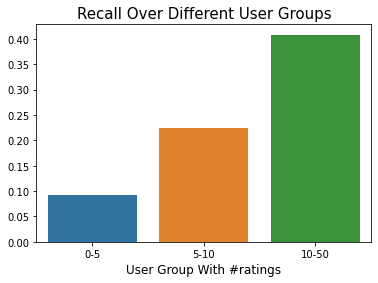

{'0-5': 0.0931, '5-10': 0.2235, '10-50': 0.408}

In [12]:
evaluation.precision_over_user_group(rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped)

Recall for each user group:  {'0-5': 0.3306, '5-10': 0.3219, '10-50': 0.3229}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


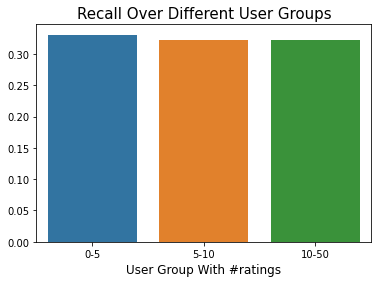

{'0-5': 0.3306, '5-10': 0.3219, '10-50': 0.3229}

In [13]:
evaluation.recall_over_user_group(rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped)

In [13]:
# Evaluation
tsr_precision = evaluation.precision_at_k(
    rating_test,
    tsr_pred,
    user_grouped = user_grouped
)
print(f"Precision: {tsr_precision}")
tsr_recall = evaluation.recall_at_k(
    rating_test,
    tsr_pred,
    user_grouped = user_grouped
)
print(f"Recall: {tsr_recall}")
tsr_ndcg = evaluation.ndcg_at_k(
    rating_test,
    tsr_pred,
    user_grouped = user_grouped
)
print(f"ndcg: {tsr_ndcg}")

Precision: 0.10493204283360792
Recall: 0.17899064676510162
Recall: 0.17582168273247448


# Weighted Bipartite SimRank

In [14]:
# Init instance
wbs = SimRank.weighted_bipartite_simrank()

In [15]:
wbs.fit(rating_train)

User count: 2000, item count: 200
Initializing User spread matrix...
GPU failed, trying with CPU...
Finished in 0.06900930404663086s!
Initializing Item spread matrix...
GPU failed, trying with CPU...
Finished in 0.017073869705200195s!
Initializing User evidence matrix...
GPU failed, trying with CPU...
Finished in 1.0615968704223633s!
Initializing Item evidence matrix...
GPU failed, trying with CPU...
Finished in 1.8112709522247314s!
Iteration 1 / 100 start:
Updating S_item with GPU...
GPU failed, trying with CPU...
Updating S_user with GPU...
GPU failed, trying with CPU...
S_user updated in 0.05030703544616699, S_item updated in 0.06699895858764648!
Iteration 2 / 100 start:
Updating S_item with GPU...
GPU failed, trying with CPU...
Updating S_user with GPU...
GPU failed, trying with CPU...
S_user updated in 0.12136197090148926, S_item updated in 0.16221213340759277!
Iteration 3 / 100 start:
Updating S_item with GPU...
GPU failed, trying with CPU...
Updating S_user with GPU...
GPU faile

In [16]:
wbs_pred = wbs.cf_recommendation(rating_test)

Count of cold start user: 0
Count of cold start item: 0


In [ ]:
# Evaluation
wbs_precision = evaluation.precision_at_k(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped
)
print(f"Precision: {tsr_precision}")
wbs_recall = evaluation.recall_at_k(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped
)
print(f"Recall: {tsr_recall}")
wbs_ndcg = evaluation.ndcg_at_k(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped
)
print(f"ndcg: {tsr_ndcg}")

In [82]:
import matplotlib.pyplot as plt

In [83]:
COL_USER = "userId"
COL_ITEM = "movieId"
COL_RATING = "rating"
COL_PREDICTION = "rating"
DEFAULT_K = 10
DEFAULT_THRESHOLD = 12

DEFAULT_USER_COL = "userId"
DEFAULT_ITEM_COL = "movieId"
DEFAULT_RATING_COL = "rating"
#DEFAULT_LABEL_COL = "label"
#DEFAULT_TIMESTAMP_COL = "timestamp"
DEFAULT_PREDICTION_COL = "rating"

In [84]:
def merge_ranking_true_pred(
    rating_true,
    rating_pred,
    col_user,
    col_item,
    col_rating,
    col_prediction,
    relevancy_method,
    user_grouped,
    k=10,
    threshold=12,
    
):
    """Filter truth and prediction data frames on common users
    Args:
        rating_true (pd.DataFrame): True DataFrame
        rating_pred (pd.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the 
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user (optional)
        threshold (float): threshold of top items per user (optional)
    Returns:
        pd.DataFrame, pd.DataFrame, int: DataFrame of recommendation hits, sorted by `col_user` and `rank`
        DataFrmae of hit counts vs actual relevant items per user number of unique user ids
    """

    # Make sure the prediction and true data frames have the same set of users
    common_users = set(rating_true[col_user]).intersection(set(rating_pred[col_user]))
    rating_true_common = rating_true[rating_true[col_user].isin(common_users)]
    rating_pred_common = rating_pred[rating_pred[col_user].isin(common_users)]
    n_users = len(common_users)

    # Return hit items in prediction data frame with ranking information. This is used for calculating NDCG and MAP.
    # Use first to generate unique ranking values for each item. This is to align with the implementation in
    # Spark evaluation metrics, where index of each recommended items (the indices are unique to items) is used
    # to calculate penalized precision of the ordered items.        

    
    # Sort dataframe by col_user and (top k) col_rating
    if relevancy_method is None:
        df_hit = rating_pred_common
    elif relevancy_method == "top_k":
        df_hit = rating_pred_common.groupby(col_user, as_index=False)\
        .apply(lambda x: x.nlargest(k, col_prediction))\
        .reset_index(drop=True)
    elif relevancy_method == "by_threshold":
        df_hit = rating_pred_common[rating_pred_common[col_prediction] >= threshold]\
        .sort_values(col_prediction, ascending=False)
    else:
        raise NotImplementedError("Invalid relevancy_method")
        
    # Add ranks
    df_hit["rank"] = df_hit.groupby(col_user, sort=False).cumcount() + 1
    
    
    df_hit = pd.merge(df_hit, rating_true_common, on=[col_user, col_item])[
        [col_user, col_item, "rank"]
    ]

    # count the number of hits vs actual relevant items per user
    df_hit_count = pd.merge(
        df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
        rating_true_common.groupby(col_user, as_index=False)[col_user].agg(
            {"actual": "count"}
        ),
        on=col_user,
    )
    
    df_hit_count = df_hit_count.join(user_grouped.set_index(col_user), on = [col_user], how = 'left')

    return df_hit, df_hit_count, n_users

In [85]:
def recall_over_user_group(
    df_true,
    df_pred,
    user_grouped,
    col_user='userId',
    col_item='movieId',
    col_rating='rating',
    col_prediction='rating',
    relevancy_method="top_k",
    k=10,
    threshold=12,
    k_items=5,
    plot=True
):
    df_hit, df_hit_count, n_users = merge_ranking_true_pred(
        df_true,
        df_pred,
        col_user,
        col_item,
        col_rating,
        col_prediction,
        relevancy_method,
        user_grouped,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0
    df_hit_count['recall'] = df_hit_count["hit"] / df_hit_count["actual"]
    user_recall = df_hit_count[['userId', 'recall']]
    groupIds = sorted(user_grouped.groupId.unique())
    groupRanges = [user_grouped[user_grouped.groupId == groupId].groupRange.unique()[0] for groupId in groupIds]
    gRecalls = list()
    for groupId in groupIds:
        idx  = user_grouped[user_grouped.groupId == groupId].userId.unique()
        count = len(idx)
        gRecall = (user_recall[user_recall.userId.isin(idx)]['recall'].sum() / count).round(4)
        gRecalls.append(gRecall)
        
    recall_dict = {key: value for key, value in zip(groupRanges, gRecalls)}
    print("Recall for each user group: ", recall_dict)
    _, ax = plt.subplots(1,1)
    x = np.arange(len(groupIds)) 
    y = gRecalls
    
    if plot:
        sns.barplot(x, y, ax = ax)
        ax.set_xticklabels(groupRanges)
        ax.set_title('Recall Over Different User Groups', size=15)
        ax.set_xlabel('User Group With #ratings', size=12)
        plt.show()
    return recall_dict

In [86]:
import seaborn as sns

Recall for each user group:  {'0-5': 0.2383, '5-10': 0.2185, '10-50': 0.1989}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


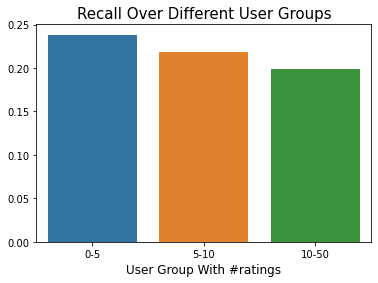

{'0-5': 0.2383, '5-10': 0.2185, '10-50': 0.1989}

In [87]:
recall_over_user_group(
    rating_test,
    wbs_pred,
    user_grouped
)

Recall for each user group:  {'0-5': 0.3106, '5-10': 0.3095, '10-50': 0.3066, '50-100': 0.3883}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


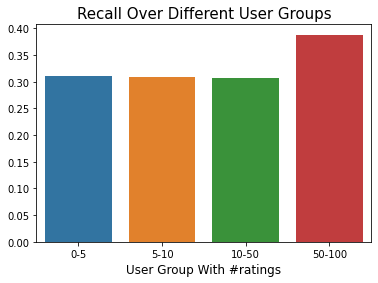

{'0-5': 0.3106, '5-10': 0.3095, '10-50': 0.3066, '50-100': 0.3883}

In [54]:
recall_over_user_group(
    rating_test,
    tsr_jac_pred,
    user_grouped
)

In [89]:
df_hit_count

,userId,hit,actual,groupId,groupRange,recall
0,58,1,9,2,5-10,0.111111
1,132,1,5,1,0-5,0.200000
2,140,1,4,1,0-5,0.250000
3,378,1,3,1,0-5,0.333333
4,394,2,13,3,10-50,0.153846
...,...,...,...,...,...,...
2370,138387,1,1,1,0-5,1.000000
2371,138406,2,6,2,5-10,0.333333
2372,138436,1,4,1,0-5,0.250000
2373,138454,1,2,1,0-5,0.500000
